import libraries

In [20]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import hydroeval as he

model library

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
#from keras.preprocessing.sequence import TimeseriesGenerator
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.optimizers import SGD,RMSprop,Adam,Adadelta,Adagrad,Adamax,Nadam

hyper parameter tuner

In [22]:
import keras_tuner as kt
import time
# model checkpoint
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.losses import MeanSquaredError,MeanAbsoluteError
from tensorflow.keras.metrics import RootMeanSquaredError


loss test

In [23]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score


load dataset

In [24]:
# def load_dataset(path):
#     return pd.read_csv(path)


# file_path = r"C:\Users\Acer\Desktop\Testing\preprocessed_dataset.csv"
# df= load_dataset(file_path)

# df

features define

In [25]:
# import datetime

# def str_to_datetime(s):
#     split = s.split('/')
#     month,day,year = int(split[0]),int(split[1]),int(split[2])

#     return datetime.datetime(year=year,month=month,day=day)

In [26]:
df.head()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
tmdate_and_time,,,,,,
2019-01-01 00:00:00,0.098577,0.000000,0.060150,0.814545,0.243077,0.0
2019-01-01 01:00:00,0.114837,0.000000,0.112782,0.847273,0.243077,0.0
2019-01-01 02:00:00,0.137195,0.008475,0.150376,0.880000,0.264615,0.0
2019-01-01 03:00:00,0.178862,0.033898,0.285714,0.909091,0.332308,0.0
2019-01-01 05:00:00,0.128049,0.279661,0.443609,0.905455,0.267692,0.0


In [27]:
df = pd.read_csv('preprocessed_dataset.csv',index_col=0)


In [28]:
df.head()

,PM2.5,O3,TEMPERATURE,PRESSURE,DEWPOINT,RAIN
tmdate_and_time,,,,,,
2019-01-01 00:00:00,0.098577,0.000000,0.060150,0.814545,0.243077,0.0
2019-01-01 01:00:00,0.114837,0.000000,0.112782,0.847273,0.243077,0.0
2019-01-01 02:00:00,0.137195,0.008475,0.150376,0.880000,0.264615,0.0
2019-01-01 03:00:00,0.178862,0.033898,0.285714,0.909091,0.332308,0.0
2019-01-01 04:00:00,0.197154,0.161017,0.394737,0.916364,0.252308,0.0


In [29]:
features = ["PM2.5",	"O3",	"TEMPERATURE",	"PRESSURE",	"DEWPOINT", 	"RAIN"]
df = df[features]

In [30]:
import numpy as np

mean_pm = df['PM2.5'].mean()
std_pm = df['PM2.5'].std()
z_scores = (df['PM2.5'] - mean_pm) / std_pm

threshold = 3
df = df[np.abs(z_scores) < threshold]

adding window 

In [31]:


def df_to_X_y(df, window_size = 5):
    df_as_np = df.to_numpy()
    X = []
    y = []
    for i in range(len(df_as_np)-window_size):
        row = [r for r in df_as_np[i:i+window_size]]
        X.append(row)
        label = df_as_np[i+window_size][0]
        y.append(label)
    return np.array(X), np.array(y)

WINDOW_SIZE = 2

X, y = df_to_X_y(df,WINDOW_SIZE)

X.shape, y.shape
     

((7564, 2, 6), (7564,))

import

In [32]:
import numpy as np
from sklearn.model_selection import KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import ParameterGrid

from tensorflow import keras
from tensorflow.keras import layers

Developing transformer model

In [33]:

def transformer_encoder(inputs, head_size, num_heads, ff_dim, dropout=0):
    # Normalization and Attention
    x = layers.LayerNormalization(epsilon=1e-6)(inputs)
    x = layers.MultiHeadAttention(
        key_dim=head_size, num_heads=num_heads, dropout=dropout
    )(x, x)
    x = layers.Dropout(dropout)(x)
    res = x + inputs

    # Feed Forward Part
    x = layers.LayerNormalization(epsilon=1e-6)(res)
    x = layers.Conv1D(filters=ff_dim, kernel_size=1, activation="relu")(x)
    x = layers.Dropout(dropout)(x)
    x = layers.Conv1D(filters=inputs.shape[-1], kernel_size=1)(x)
    return x + res

from tensorflow.keras.callbacks import EarlyStopping

def build_model(hp):
    inputs = keras.Input(shape=input_shape)
    x = inputs

    for i in range(hp.Int('num_transformer_blocks', min_value=2, max_value=8, step=2)):
        x = transformer_encoder(x,
                               hp.Int('head_size', min_value=8, max_value=256, step=32),
                               hp.Int('num_heads', min_value=2, max_value=16),
                               hp.Int('ff_dim', min_value=4, max_value=64),
                               hp.Float(f'dropout_{i}', min_value=0.1, max_value=0.6))

    x = layers.GlobalAveragePooling1D(data_format="channels_first")(x)

    for i in range(hp.Int('num_mlp_layers', min_value=1, max_value=3)):
        x = layers.Dense(hp.Int(f'mlp_units_{i}', min_value=32, max_value=256, step=32))(x)
        x = layers.Activation('relu')(x)
        x = layers.Dropout(hp.Float(f'mlp_dropout_{i}', min_value=0.1, max_value=0.6))(x)

    outputs = layers.Dense(1)(x)
    model = keras.Model(inputs, outputs)

    # Choose optimizer and learning rate
    optimizer = hp.Choice('optimizer', values=['adam', 'adamax'])
    learning_rate = hp.Float('learning_rate', min_value=1e-4, max_value=1e-2)

    if optimizer == 'adam':
        opt = Adam(learning_rate=learning_rate)
    else:
        opt = Adamax(learning_rate=learning_rate, beta_1=0.9, beta_2=0.999)

    model.compile(optimizer=opt, loss=MeanSquaredError(), metrics=['mae', RootMeanSquaredError()])

    return model

In [34]:
input_shape = X.shape[1:]
input_shape

(2, 6)

importing for training

In [35]:
import numpy as np
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.optimizers import Adam, Adamax
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from kerastuner.tuners import RandomSearch
from kerastuner.engine.hyperparameters import HyperParameters
import keras_tuner as kt

model building

In [41]:

# Define your input shape
input_shape = X.shape[1:]


# Assume you have your data X and y
best_model_hyperparameters = None
best_model_mae = float('inf')

worst_model_hyperparameters = None
worst_model_mae = float('-inf')

# Initialize K-Fold cross-validation for the outer loop
outer_cv = KFold(n_splits=5, shuffle=True, random_state=42)


# Perform Nested Cross-Validation
nested_scores = []

for fold_outer_idx, (train_ix, test_ix) in enumerate(outer_cv.split(X)):
    X_train_outer, X_test_outer = X[train_ix], X[test_ix]
    y_train_outer, y_test_outer = y[train_ix], y[test_ix]

    # Inner loop for hyperparameter tuning
    inner_cv = KFold(n_splits=3, shuffle=True, random_state=42)

    for fold_idx, (train_ix_inner, val_ix) in enumerate(inner_cv.split(X_train_outer)):
        X_train_inner, X_val = X_train_outer[train_ix_inner], X_train_outer[val_ix]
        y_train_inner, y_val = y_train_outer[train_ix_inner], y_train_outer[val_ix]

        tuner = kt.RandomSearch(
            build_model,
            objective='val_loss',
            max_trials=5,
            # directory=f'C:\Users\Acer\Desktop\TR tuner val/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            # project_name=f'C:\Users\Acer\Desktop\TR tuner val/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'
            
            #directory=f'/content/drive/MyDrive/research/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
            #project_name=f'/content/drive/MyDrive/research/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'
            directory = f'C:/Users/Acer/Desktop/TR tuner val/keras_tuner_random_dir_fold_tf_{fold_outer_idx}_{fold_idx}',
project_name = f'C:/Users/Acer/Desktop/TR tuner val/hyperparameter_random_tuning_fold_tf_{fold_outer_idx}_{fold_idx}'



        )

        # Search for the best hyperparameters
        tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)

        # tuner.search(X_train_inner, y_train_inner, validation_data=(X_val, y_val), epochs=30)  # Adjust epochs as needed

        best_hps = tuner.oracle.get_best_trials(1)[0].hyperparameters
        print(f"Best hyperparameters for fold {fold_idx}: {best_hps}")

        model = build_model(best_hps)
        es = [keras.callbacks.EarlyStopping(patience=10, restore_best_weights=True)]

        model.fit(
            X_train_inner,
            y_train_inner,
            validation_data=(X_val, y_val),
            epochs=10,
            batch_size=32,
            callbacks=[es],
        )

        y_pred = model.predict(X_val)
        mae = mean_squared_error(y_val, y_pred)

         # Update best model
        if mae < best_model_mae:
            best_model_mae = mae
            best_model_hyperparameters = best_hps
            best_model = model

        # Update worst model
        if mae > worst_model_mae:
            worst_model_mae = mae
            worst_model_hyperparameters = best_hps
            worst_model = model

    # Now that we have the best and worst models, evaluate them on the test set
    start_time = time.time()
    y_pred_best = best_model.predict(X_test_outer)
    y_pred_worst = worst_model.predict(X_test_outer)
    end_time = time.time()

    mse_best = mean_squared_error(y_test_outer, y_pred_best)
    mae_best = mean_absolute_error(y_test_outer, y_pred_best)
    rmse_best = np.sqrt(mse_best)

    nse_best = he.evaluator(he.nse, y_pred_best, y_test_outer)
    kge_best, r, alpha, beta = he.evaluator(he.kge, y_pred_best, y_test_outer)
    print("Best Model:")
    print("KGE : ", kge_best)

    r2_best = r2_score(y_test_outer, y_pred_best)
    time_duration = end_time - start_time

    mse_worst = mean_squared_error(y_test_outer, y_pred_worst)
    mae_worst = mean_absolute_error(y_test_outer, y_pred_worst)
    rmse_worst = np.sqrt(mse_worst)

    nse_worst = he.evaluator(he.nse, y_pred_worst, y_test_outer)
    kge_worst, r, alpha, beta = he.evaluator(he.kge, y_pred_worst, y_test_outer)
    print("Worst Model:")
    print("KGE : ", kge_worst)

    r2_worst = r2_score(y_test_outer, y_pred_worst)
    time_duration = end_time - start_time

    nested_scores.append({
        "Best Model": {
            "MSE": mse_best,
            "R^2": r2_best,
            "RMSE": rmse_best,
            "MAE": mae_best,
            "testing time": time_duration,
            "nse": nse_best,
            "kge": kge_best
        },
        "Worst Model": {
            "MSE": mse_worst,
            "R^2": r2_worst,
            "RMSE": rmse_worst,
            "MAE": mae_worst,
            "testing time": time_duration,
            "nse": nse_worst,
            "kge": kge_worst
        }
    })

# Save the best and worst hyperparameters
print("Best Hyperparameters:", best_model_hyperparameters)
print("Best MAE:", best_model_mae)

print("Worst Hyperparameters:", worst_model_hyperparameters)
print("Worst MAE:", worst_model_mae)


# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")

Trial 5 Complete [00h 03m 45s]
val_loss: 0.0002722826029639691

Best val_loss So Far: 0.0002722826029639691
Total elapsed time: 00h 19m 55s
Best hyperparameters for fold 2: <keras_tuner.src.engine.hyperparameters.hyperparameters.HyperParameters object at 0x00000231811F3FE0>
Epoch 1/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 10s 27ms/step - loss: 0.0132 - mae: 0.0749 - root_mean_squared_error: 0.1101 - val_loss: 0.0011 - val_mae: 0.0231 - val_root_mean_squared_error: 0.0326
Epoch 2/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0017 - mae: 0.0312 - root_mean_squared_error: 0.0411 - val_loss: 0.0010 - val_mae: 0.0234 - val_root_mean_squared_error: 0.0321
Epoch 3/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 22ms/step - loss: 0.0015 - mae: 0.0294 - root_mean_squared_error: 0.0388 - val_loss: 9.1471e-04 - val_mae: 0.0216 - val_root_mean_squared_error: 0.0302
Epoch 4/10
127/127 ━━━━━━━━━━━━━━━━━━━━ 3s 23ms/step - loss: 0.0013 - mae: 0.0270 - root_mean_squared_error: 0.0355 - val_loss: 8.2507e-04 - val_ma

Nested cross validation scores

In [42]:
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Worst Model']['MSE']}, R^2: {scores['Worst Model']['R^2']}, RMSE: {scores['Worst Model']['RMSE']}, MAE: {scores['Worst Model']['MAE']}, kge: {scores['Worst Model']['kge']}, nse: {scores['Worst Model']['nse']}, time: {scores['Worst Model']['testing time']}")

# Calculate overall statistics
all_mse = [scores['Worst Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Worst Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Worst Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Worst Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Worst Model']['kge'] for scores in nested_scores]
all_nse = [scores['Worst Model']['nse'] for scores in nested_scores]
all_time = [scores['Worst Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.00040240363506305473, R^2: 0.6478868492723988, RMSE: 0.020060000873954487, MAE: 0.014383771596427147, kge: [0.61173355], nse: [0.64788685], time: 1.0735564231872559

Fold 2 - MSE: 0.0007801379572551855, R^2: 0.28368133265946316, RMSE: 0.027930949809399346, MAE: 0.021142903623980882, kge: [0.20474998], nse: [0.28368133], time: 1.2286972999572754

Fold 3 - MSE: 0.0007958308490518863, R^2: 0.2679559493800826, RMSE: 0.02821047410186306, MAE: 0.02164346524029253, kge: [0.1896998], nse: [0.26795595], time: 1.525153636932373

Fold 4 - MSE: 0.0008017696969918283, R^2: 0.2585509368662201, RMSE: 0.028315538084094892, MAE: 0.021534274365499897, kge: [0.18246755], nse: [0.25855094], time: 1.299881935119629

Fold 5 - MSE: 0.0007805982515792549, R^2: 0.2609913844434707, RMSE: 0.027939188455988747, MAE: 0.02101273987942711, kge: [0.18256488], nse: [0.26099138], time: 1.6167654991149902
Mean MSE: 0.001
Mean MAE: 0.020
Mean RMSE: 0.026
Mean R^2: 0.344
Me

using the nested_scores as needed

In [43]:
# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")

# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")


Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0003487483424229552, R^2: 0.6948365597086787, RMSE: 0.018674805016999647, MAE: 0.013599531323452171, kge: [0.78941712], nse: [0.69483656]

Fold 2 - MSE: 0.00032679724752380954, R^2: 0.6999364450097652, RMSE: 0.018077534331977067, MAE: 0.012858168405678353, kge: [0.79251496], nse: [0.69993645]

Fold 3 - MSE: 0.0003253935597433681, R^2: 0.7006871249035497, RMSE: 0.018038668458158658, MAE: 0.011801474150962731, kge: [0.67718119], nse: [0.70068712]

Fold 4 - MSE: 0.0002990531934714669, R^2: 0.72344588357666, RMSE: 0.01729315452632824, MAE: 0.011578132287542994, kge: [0.69532326], nse: [0.72344588]

Fold 5 - MSE: 0.00033050041548680936, R^2: 0.6871083761773369, RMSE: 0.018179670389938573, MAE: 0.011826984812464872, kge: [0.68024752], nse: [0.68710838]
Mean MSE: 0.000
Mean MAE: 0.012
Mean RMSE: 0.018
Mean R^2: 0.701
Mean kge: 0.727
Mean nse: 0.701
Mean time: 1.349


graph plotting

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


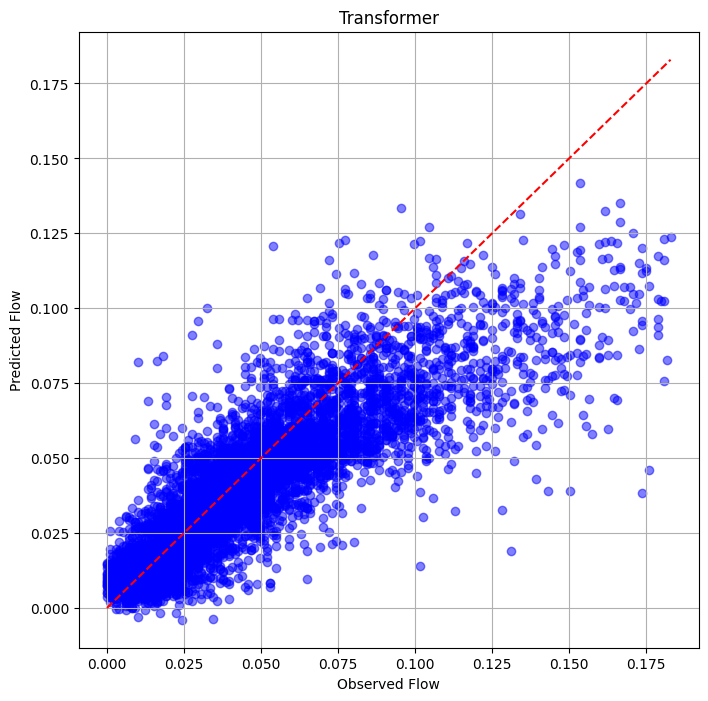

In [44]:


import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()


C:\Users\Acer\Desktop\Testing

In [50]:
best_model.save(r'C:\Users\Acer\Desktop\Testing\best_model_transformer_4i.h5')


optimizer test

In [51]:

# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)

Optimizer: Adam
Learning Rate: 0.006195317022502422


In [52]:


# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
multi_head_attention_2: 0.4382495879494893
dropout_9: 0.4382495879494893
dropout_10: 0.4382495879494893
multi_head_attention_3: 0.11956174765417202
dropout_12: 0.11956174765417202
dropout_13: 0.11956174765417202
multi_head_attention_4: 0.1
dropout_15: 0.1
dropout_16: 0.1
multi_head_attention_5: 0.1
dropout_18: 0.1
dropout_19: 0.1
dropout_20: 0.2598236354294935


In [53]:

best_hyperparameters_dict = best_model_hyperparameters.values
worst_hyperparameters_dict = worst_model_hyperparameters.values

print("Best Hyperparameters:", best_hyperparameters_dict)
print("Worst Hyperparameters:", worst_hyperparameters_dict)

Best Hyperparameters: {'num_transformer_blocks': 4, 'head_size': 72, 'num_heads': 3, 'ff_dim': 28, 'dropout_0': 0.4382495879494893, 'dropout_1': 0.11956174765417202, 'num_mlp_layers': 1, 'mlp_units_0': 192, 'mlp_dropout_0': 0.2598236354294935, 'optimizer': 'adam', 'learning_rate': 0.006195317015685493, 'dropout_2': 0.1, 'dropout_3': 0.1}
Worst Hyperparameters: {'num_transformer_blocks': 4, 'head_size': 168, 'num_heads': 14, 'ff_dim': 50, 'dropout_0': 0.4103581813645787, 'dropout_1': 0.2249695646832647, 'num_mlp_layers': 2, 'mlp_units_0': 128, 'mlp_dropout_0': 0.1255270943771584, 'optimizer': 'adamax', 'learning_rate': 0.009778563518232601, 'dropout_2': 0.5000597828944017, 'dropout_3': 0.5513440242431882, 'dropout_4': 0.2631426309723979, 'dropout_5': 0.3231279728497686, 'mlp_units_1': 128, 'mlp_dropout_1': 0.12178760432651667}


In [55]:

# from keras.utils import plot_model
# # Visualize the model architecture and save the diagram to a file
# plot_model(best_model, to_file='tf_model.png', show_shapes=True, show_layer_names=True

In [56]:

# Assuming best_model is your trained model

# Function to extract dropout rate from a layer
def get_dropout_rate(layer):
    if hasattr(layer, 'rate'):
        return layer.rate
    elif hasattr(layer, 'dropout'):
        return layer.dropout
    else:
        return None

# Iterate through layers of the model and find the dropout rates
dropout_rates = []

for layer in best_model.layers:
    rate = get_dropout_rate(layer)
    if rate is not None:
        dropout_rates.append((layer.name, rate))

# Print the dropout rates
print("Dropout Rates:")
for layer_name, rate in dropout_rates:
    print(f"{layer_name}: {rate}")

Dropout Rates:
multi_head_attention_2: 0.4382495879494893
dropout_9: 0.4382495879494893
dropout_10: 0.4382495879494893
multi_head_attention_3: 0.11956174765417202
dropout_12: 0.11956174765417202
dropout_13: 0.11956174765417202
multi_head_attention_4: 0.1
dropout_15: 0.1
dropout_16: 0.1
multi_head_attention_5: 0.1
dropout_18: 0.1
dropout_19: 0.1
dropout_20: 0.2598236354294935


In [57]:


# Print or use the nested_scores as needed
print("Nested Cross-Validation Scores:")
for i, scores in enumerate(nested_scores):
    print(f"\nFold {i + 1} - MSE: {scores['Best Model']['MSE']}, R^2: {scores['Best Model']['R^2']}, RMSE: {scores['Best Model']['RMSE']}, MAE: {scores['Best Model']['MAE']}, kge: {scores['Best Model']['kge']}, nse: {scores['Best Model']['nse']}")


# Calculate overall statistics
all_mse = [scores['Best Model']['MSE'] for scores in nested_scores]
all_mae = [scores['Best Model']['MAE'] for scores in nested_scores]
all_rsme = [scores['Best Model']['RMSE'] for scores in nested_scores]
all_r2 = [scores['Best Model']['R^2'] for scores in nested_scores]
all_kge = [scores['Best Model']['kge'] for scores in nested_scores]
all_nse = [scores['Best Model']['nse'] for scores in nested_scores]
all_time = [scores['Best Model']['testing time'] for scores in nested_scores]
mean_mse = np.mean(all_mse)
mean_mae = np.mean(all_mae)
mean_rsme = np.mean(all_rsme)
mean_r2 = np.mean(all_r2)
mean_kge = np.mean(all_kge)
mean_nse = np.mean(all_nse)
mean_time = np.mean(all_time)

print(f"Mean MSE: {mean_mse:.3f}")
print(f"Mean MAE: {mean_mae:.3f}")
print(f"Mean RMSE: {mean_rsme:.3f}")
print(f"Mean R^2: {mean_r2:.3f}")
print(f"Mean kge: {mean_kge:.3f}")
print(f"Mean nse: {mean_nse:.3f}")
print(f"Mean time: {mean_time:.3f}")

Nested Cross-Validation Scores:

Fold 1 - MSE: 0.0003487483424229552, R^2: 0.6948365597086787, RMSE: 0.018674805016999647, MAE: 0.013599531323452171, kge: [0.78941712], nse: [0.69483656]

Fold 2 - MSE: 0.00032679724752380954, R^2: 0.6999364450097652, RMSE: 0.018077534331977067, MAE: 0.012858168405678353, kge: [0.79251496], nse: [0.69993645]

Fold 3 - MSE: 0.0003253935597433681, R^2: 0.7006871249035497, RMSE: 0.018038668458158658, MAE: 0.011801474150962731, kge: [0.67718119], nse: [0.70068712]

Fold 4 - MSE: 0.0002990531934714669, R^2: 0.72344588357666, RMSE: 0.01729315452632824, MAE: 0.011578132287542994, kge: [0.69532326], nse: [0.72344588]

Fold 5 - MSE: 0.00033050041548680936, R^2: 0.6871083761773369, RMSE: 0.018179670389938573, MAE: 0.011826984812464872, kge: [0.68024752], nse: [0.68710838]
Mean MSE: 0.000
Mean MAE: 0.012
Mean RMSE: 0.018
Mean R^2: 0.701
Mean kge: 0.727
Mean nse: 0.701
Mean time: 1.349


In [58]:


# Assuming best_model is your trained model
optimizer = best_model.optimizer
learning_rate = float(optimizer.learning_rate.numpy())

# Print the optimizer and learning rate
print("Optimizer:", type(optimizer).__name__)
print("Learning Rate:", learning_rate)
     

Optimizer: Adam
Learning Rate: 0.006195317022502422


In [59]:
# Assuming best_model is your final trained model
best_model.save(r'C:\Users\Acer\Desktop\Testing\best_model_transformer.h5')

237/237 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


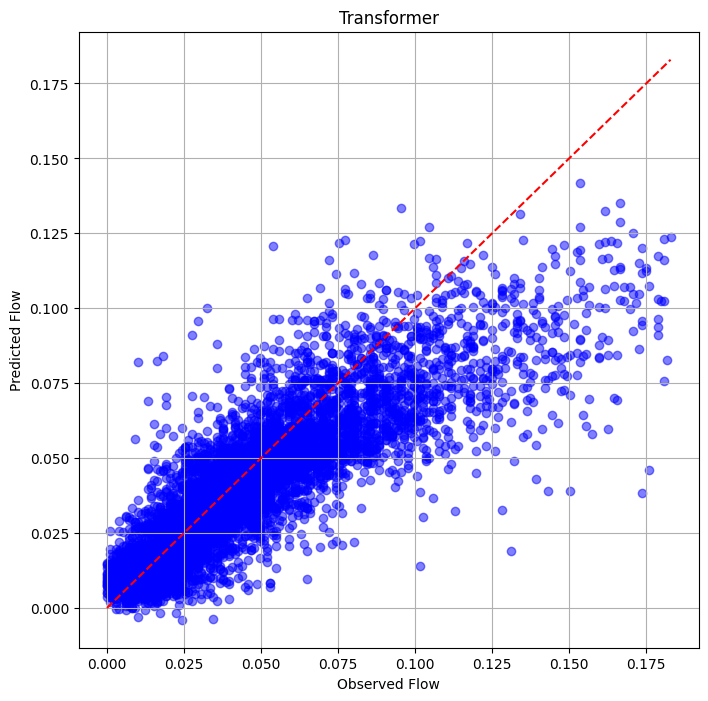

In [60]:


import matplotlib.pyplot as plt

# Assuming you have arrays y_pred and y_observed
# y_pred and y_observed should have the same length
y_pred = best_model.predict(X).flatten()
y_observed = y
plt.figure(figsize=(8, 8))
plt.scatter(y_observed, y_pred, color='blue', alpha=0.5)
plt.plot([min(y_observed), max(y_observed)], [min(y_observed), max(y_observed)], color='red', linestyle='--')
plt.title('Transformer')
plt.xlabel('Observed Flow')
plt.ylabel('Predicted Flow')
plt.grid(True)
plt.show()
